# Purpose

This script is used to apply the 8 timseries cross-validation models to the the test data (for 2022). 

In [78]:
#high level modules
import os
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [79]:
# custom modules
this_dir = "/Users/steeleb/Documents/GitHub/NASA-NW/modeling/SMR_temp_forecast/arNN/"

imp.load_source("universals", os.path.join(this_dir, "universal_functions.py"))
from universals import load_pickle_file, twotemp_labels_features_test, predict_2_values_test, return_test_error_metrics

imp.load_source("vis", os.path.join(this_dir, "vis_functions.py"))
from vis import ts_plot, create_scatter_plot_test

We need to read in the transformed test data, apply the models, and save the resictions.

In [80]:
# import test data
file_path = os.path.expanduser("/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/")

test_fn = os.path.join(file_path, "t2022_standardized_v2024-11-25.csv")
with open(test_fn) as f:
    test = pd.read_csv(f, sep=',')

And we need to filter this for our target date - Jul 1 through Sept 11.

In [81]:
# arrange the data by date
test['date'] = pd.to_datetime(test['date'])
test = test.sort_values(by='date')
test = test.loc[test['date'].between('2022-07-01', '2022-09-11')]

Now we need to apply the models to the test data, but first we need to format the data for the models

In [82]:
test_features, test_labels = twotemp_labels_features_test(test)
test_features.shape, test_labels.shape

((73, 166), (73, 2))

Load the models

In [83]:
# load the models
model_dir = '/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/models/leaky_basic_5/'

models = [f for f in os.listdir(model_dir) if 'history' not in f]
models.sort()

model_1 = load_pickle_file(models[0], model_dir)
model_2 = load_pickle_file(models[1], model_dir)
model_3 = load_pickle_file(models[2], model_dir)
model_4 = load_pickle_file(models[3], model_dir)
model_5 = load_pickle_file(models[4], model_dir)
model_6 = load_pickle_file(models[5], model_dir)
model_7 = load_pickle_file(models[6], model_dir)
model_8 = load_pickle_file(models[7], model_dir)


Now we need to apply the models to the test data and get the resictions, for which we also need the standarization parameters to back calculate.

In [84]:
transform = pd.read_csv(os.path.join("/Users/steeleb/Documents/GitHub/NASA-NW/data/NN_train_val_test/SMR_forecast/", "mean_std_train_val_t2022_v2024-11-25.csv"), sep=',')
transform = transform.rename(columns={"Unnamed: 0": "feature"}).set_index("feature")

t_mean_1m = transform['mean'].get('mean_1m_temp_degC')
t_std_1m = transform['std'].get('mean_1m_temp_degC')

t_mean_05m = transform['mean'].get('mean_0_5m_temp_degC')
t_std_05m = transform['std'].get('mean_0_5m_temp_degC')

test["pred_1m_1"], test["pred_05m_1"] = predict_2_values_test(model_1, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_2"], test["pred_05m_2"] = predict_2_values_test(model_2, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_3"], test["pred_05m_3"] = predict_2_values_test(model_3, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_4"], test["pred_05m_4"] = predict_2_values_test(model_4, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_5"], test["pred_05m_5"] = predict_2_values_test(model_5, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_6"], test["pred_05m_6"] = predict_2_values_test(model_6, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_7"], test["pred_05m_7"] = predict_2_values_test(model_7, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)
test["pred_1m_8"], test["pred_05m_8"] = predict_2_values_test(model_8, test_features, t_mean_1m, t_mean_05m, t_std_1m, t_std_05m)

And now, let's make the ensemble prediction to assess the model performance.

In [85]:
test["ts_cv_ensemble_pred_1m"] = np.mean(test[['pred_1m_1', 'pred_1m_2', 'pred_1m_3', 'pred_1m_4', 'pred_1m_5', 'pred_1m_6', 'pred_1m_7', 'pred_1m_8']], axis=1)
test["ts_cv_ensemble_pred_05m"] = np.mean(test[['pred_05m_1', 'pred_05m_2', 'pred_05m_3', 'pred_05m_4', 'pred_05m_5', 'pred_05m_6', 'pred_05m_7', 'pred_05m_8']], axis=1)

In order to compare these with the actual values, we need to load the actual values and calculate the performance metrics. To do this, we will back-calculate using the mean and standard deviation.

In [86]:
test['mean_1m_temp_degC'] = test['mean_1m_temp_degC'] * t_std_1m + t_mean_1m
test['mean_0_5m_temp_degC'] = test['mean_0_5m_temp_degC'] * t_std_05m + t_mean_05m

Let's look at the data from 1m first:

In [87]:
return_test_error_metrics(np.sqrt(test["mean_1m_temp_degC"]), np.sqrt(test["ts_cv_ensemble_pred_1m"]))

Test Datset Error Metrics:
Mean Squared Error: 0.21877385471042965
Mean Absolute Error: 0.3672928560445248
Root Mean Squared Error: 0.4677326744096778
Mean Absolute Percentage Error: 0.021841608458574843


(0.21877385471042965,
 0.3672928560445248,
 0.4677326744096778,
 0.021841608458574843)

And then the data from 0-5m:

In [88]:
return_test_error_metrics(test["mean_0_5m_temp_degC"], test["ts_cv_ensemble_pred_05m"])

Test Datset Error Metrics:
Mean Squared Error: 0.16551788737080209
Mean Absolute Error: 0.3431207201461144
Root Mean Squared Error: 0.4068388960888598
Mean Absolute Percentage Error: 0.02437517584990307


(0.16551788737080209,
 0.3431207201461144,
 0.4068388960888598,
 0.02437517584990307)

Let's look at this in context of the data:

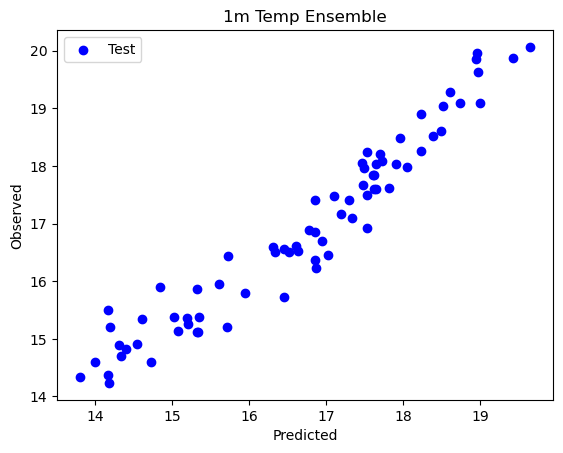

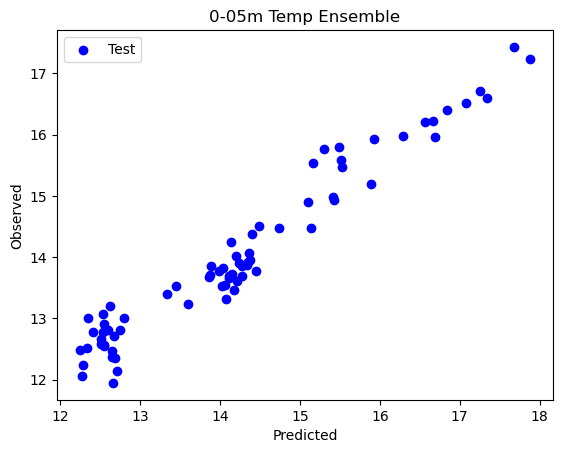

In [89]:
create_scatter_plot_test("1m Temp Ensemble", np.sqrt(test["ts_cv_ensemble_pred_1m"]), np.sqrt(test["mean_1m_temp_degC"]))
create_scatter_plot_test("0-05m Temp Ensemble", test["ts_cv_ensemble_pred_05m"], test["mean_0_5m_temp_degC"])

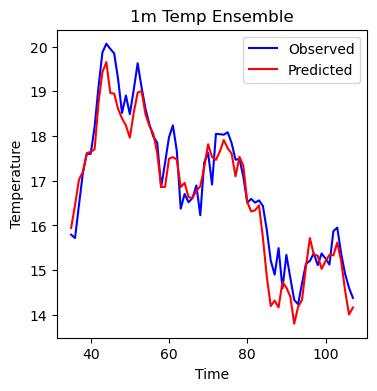

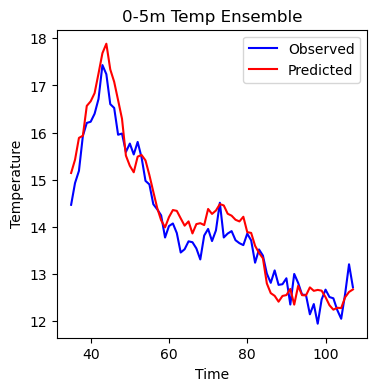

In [90]:
ts_plot(np.sqrt(test["mean_1m_temp_degC"]), np.sqrt(test["ts_cv_ensemble_pred_1m"]), "1m Temp Ensemble")
ts_plot(test["mean_0_5m_temp_degC"], test["ts_cv_ensemble_pred_05m"], "0-5m Temp Ensemble")


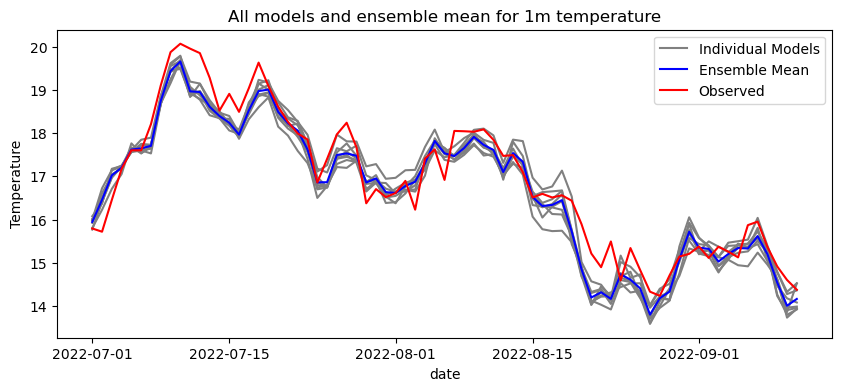

In [91]:
plt.figure(figsize=(10,4))
plt.plot(test['date'], np.sqrt(test["pred_1m_1"]), label="Individual Models", color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_2"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_3"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_4"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_5"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_6"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_7"]), color='grey')
plt.plot(test['date'], np.sqrt(test["pred_1m_8"]), color='grey')
plt.plot(test['date'], np.sqrt(test["ts_cv_ensemble_pred_1m"]), label="Ensemble Mean", color='blue')
plt.plot(test['date'], np.sqrt(test["mean_1m_temp_degC"]), label="Observed", color='red')
plt.xlabel("date")
plt.ylabel("Temperature")
plt.legend()
plt.title("All models and ensemble mean for 1m temperature")
plt.show()

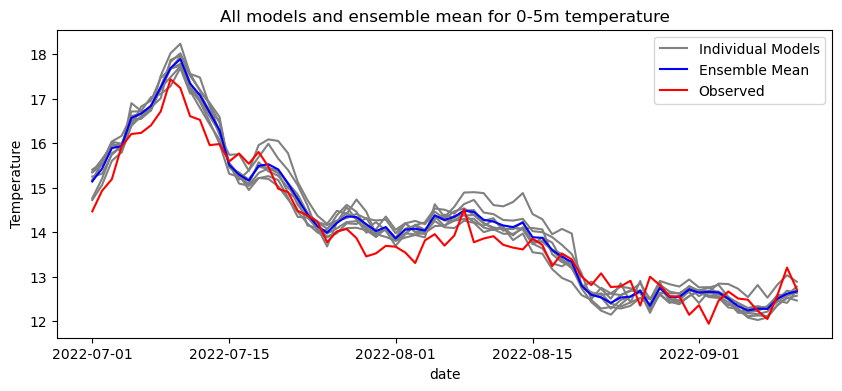

In [92]:
plt.figure(figsize=(10,4))
plt.plot(test['date'], test["pred_05m_1"], label="Individual Models", color='grey')
plt.plot(test['date'], test["pred_05m_2"], color='grey')
plt.plot(test['date'], test["pred_05m_3"], color='grey')
plt.plot(test['date'], test["pred_05m_4"], color='grey')
plt.plot(test['date'], test["pred_05m_5"], color='grey')
plt.plot(test['date'], test["pred_05m_6"], color='grey')
plt.plot(test['date'], test["pred_05m_7"], color='grey')
plt.plot(test['date'], test["pred_05m_8"], color='grey')
plt.plot(test['date'], test["ts_cv_ensemble_pred_05m"], label="Ensemble Mean", color='blue')
plt.plot(test['date'], test["mean_0_5m_temp_degC"], label="Observed", color='red')
plt.xlabel("date")
plt.ylabel("Temperature")
plt.legend()
plt.title("All models and ensemble mean for 0-5m temperature")
plt.show()

These actually look quite good. While the model doesn't capture the highest values at 1m, there were zero instances in the training/validation set with values that high, so it's not surprising that the model doesn't capture them. The model does a good job of capturing the general trends in the data and does very well with the high 0-5m values.

Let's look at the error metrics for the models:

**1m results - in forecast mode**

Mean Squared Error: 0.22

Mean Absolute Error: 0.37

Root Mean Squared Error: 0.47

Mean Absolute Percentage Error: 2.18

**1m baseline**

Mean Squared Error for 1m baseline: 0.23

Mean Absolute Error for 1m baseline: 0.38

MAPE: 2.46%


**0-5m results - in forecast mode**

Mean Squared Error: 0.17

Mean Absolute Error: 0.34

Root Mean Squared Error: 0.41

Mean Absolute Percentage Error: 2.43%

**0-5m baseline**

Mean Squared Error for 0-5m baseline : 0.11

Mean Absolute Error for 0-5m baseline : 0.28

MAPE: 2.09%

## Create timeseries residual plot

Calculate residuals

In [93]:
test['res_1m_1'] = np.sqrt(test['pred_1m_1']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_2'] = np.sqrt(test['pred_1m_2']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_3'] = np.sqrt(test['pred_1m_3']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_4'] = np.sqrt(test['pred_1m_4']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_5'] = np.sqrt(test['pred_1m_5']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_6'] = np.sqrt(test['pred_1m_6']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_7'] = np.sqrt(test['pred_1m_7']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_8'] = np.sqrt(test['pred_1m_8']) - np.sqrt(test['mean_1m_temp_degC'])
test['res_1m_ensemble'] = np.sqrt(test['ts_cv_ensemble_pred_1m']) - np.sqrt(test['mean_1m_temp_degC'])

test['res_05m_1'] = test['pred_05m_1'] - test['mean_0_5m_temp_degC']
test['res_05m_2'] = test['pred_05m_2'] - test['mean_0_5m_temp_degC']
test['res_05m_3'] = test['pred_05m_3'] - test['mean_0_5m_temp_degC']
test['res_05m_4'] = test['pred_05m_4'] - test['mean_0_5m_temp_degC']
test['res_05m_5'] = test['pred_05m_5'] - test['mean_0_5m_temp_degC']
test['res_05m_6'] = test['pred_05m_6'] - test['mean_0_5m_temp_degC']
test['res_05m_7'] = test['pred_05m_7'] - test['mean_0_5m_temp_degC']
test['res_05m_8'] = test['pred_05m_8'] - test['mean_0_5m_temp_degC']
test['res_05m_ensemble'] = test['ts_cv_ensemble_pred_05m'] - test['mean_0_5m_temp_degC']


In [94]:
yit = test.filter(['mean_0_5m_temp_degC', 'mean_1m_temp_degC'])
yit = yit.shift(periods=1).rename(columns={'mean_0_5m_temp_degC': 'yit_mean_0_5m_temp_degC', 
                                     'mean_1m_temp_degC': 'yit_mean_1m_temp_degC'})
print(yit)
test = pd.concat([test, yit], axis=1)
test['res_yit_0_5m'] = test['yit_mean_0_5m_temp_degC'] - test['mean_0_5m_temp_degC']
test['res_yit_1m'] = np.sqrt(test['yit_mean_1m_temp_degC']) - np.sqrt(test['mean_1m_temp_degC'])


     yit_mean_0_5m_temp_degC  yit_mean_1m_temp_degC
35                       NaN                    NaN
36                 14.467537             249.425166
37                 14.929811             247.060763
38                 15.188170             270.712178
39                 15.927849             294.877584
..                       ...                    ...
103                12.484075             251.856900
104                12.235113             254.429084
105                12.050315             236.072982
106                12.573259             222.442310
107                13.205660             213.228139

[73 rows x 2 columns]


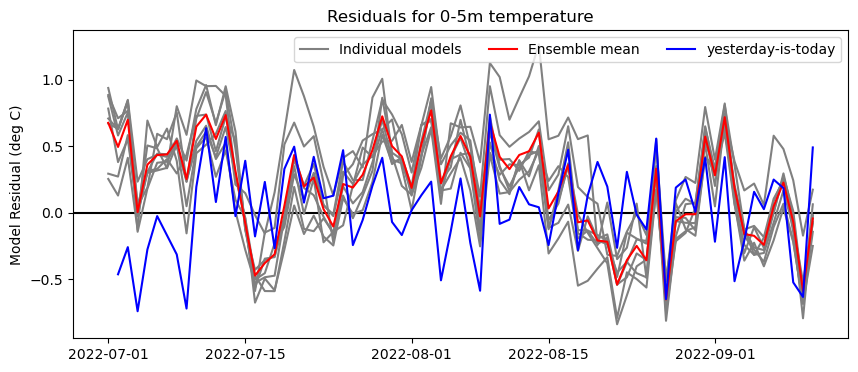

In [95]:
plt.figure(figsize=(10,4))
plt.axhline(0, color = 'black')
plt.plot(test['date'], test["res_05m_1"], label="Individual models", color='grey')
plt.plot(test['date'], test["res_05m_2"], color='grey')
plt.plot(test['date'], test["res_05m_3"], color='grey')
plt.plot(test['date'], test["res_05m_4"], color='grey')
plt.plot(test['date'], test["res_05m_5"], color='grey')
plt.plot(test['date'], test["res_05m_6"], color='grey')
plt.plot(test['date'], test["res_05m_7"], color='grey')
plt.plot(test['date'], test["res_05m_8"], color='grey')
plt.plot(test['date'], test["res_05m_ensemble"], label="Ensemble mean", color='red')
plt.plot(test['date'], test["res_yit_0_5m"], label = "yesterday-is-today", color = 'blue')
plt.ylabel("Model Residual (deg C)")
plt.legend(ncols = 3)
plt.title("Residuals for 0-5m temperature")
plt.show()

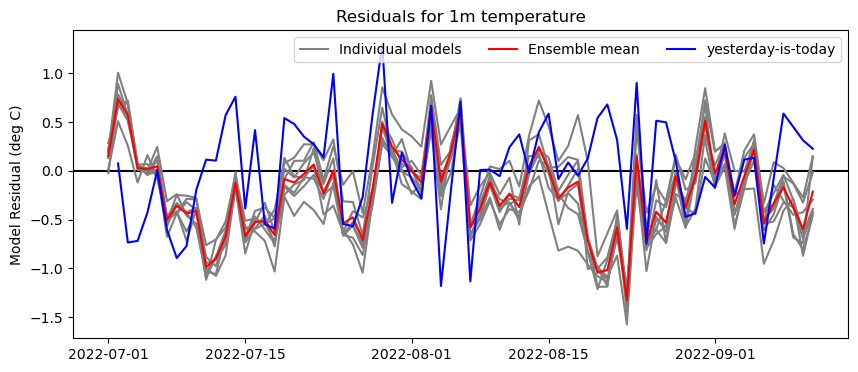

In [96]:
plt.figure(figsize=(10,4))
plt.axhline(0, color = 'black')
plt.plot(test['date'], test["res_1m_1"], label="Individual models", color='grey')
plt.plot(test['date'], test["res_1m_2"], color='grey')
plt.plot(test['date'], test["res_1m_3"], color='grey')
plt.plot(test['date'], test["res_1m_4"], color='grey')
plt.plot(test['date'], test["res_1m_5"], color='grey')
plt.plot(test['date'], test["res_1m_6"], color='grey')
plt.plot(test['date'], test["res_1m_7"], color='grey')
plt.plot(test['date'], test["res_1m_8"], color='grey')
plt.plot(test['date'], test["res_1m_ensemble"], label="Ensemble mean", color='red')
plt.plot(test['date'], test["res_yit_1m"], label = "yesterday-is-today", color = 'blue')
plt.ylabel("Model Residual (deg C)")
plt.legend(ncols = 3)
plt.title("Residuals for 1m temperature")
plt.show()